In [3]:
# deep learning 
import tensorflow.compat.v1 as tf #YD: add.compat.v1 to invert to earlier version
# tf.disable_v2_behavior() #YD
tf.compat.v1.disable_eager_execution()
import keras.backend as K
from keras.layers import GaussianNoise, Dense, Activation, Input
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment as linear_assignment
# general tools
import os
import numpy as np
from tqdm import tqdm
from preprocess import *
from io import *

os.chdir("..")
# check current working directory
print("Current Working Directory: ", os.getcwd())

# check if eager executation is enabled
print("Eager execution: {}".format(tf.executing_eagerly()))

Using TensorFlow backend.


Current Working Directory:  /Users/yufeideng/Documents/GitHub/bis687-project
Eager execution: False


In [50]:
## Define activation and loss functions (neglected ZINB and MSE methods)

MeanAct = lambda x: tf.clip_by_value(K.exp(x), 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

def weight_mse(x_count, x, recon_x):
    weight_loss = x_count * tf.square(x - recon_x)
    return tf.reduce_mean(weight_loss)


def mask_mse(x_count, x, recon_x):
    loss = tf.sign(x_count) * tf.square(x - recon_x)
    return tf.reduce_mean(loss)

def multinomial(y_true, y_pred):
    loss = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
    return loss

def _nan2zero(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)


def NB(theta, y_true, y_pred, mask = False, debug = False, mean = False):
    eps = 1e-10
    scale_factor = 1.0
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32) * scale_factor
    if mask:
        nelem = _nelem(y_true)
        y_true = _nan2zero(y_true)
    theta = tf.minimum(theta, 1e6)
    t1 = tf.lgamma(theta + eps) + tf.lgamma(y_true + 1.0) - tf.lgamma(y_true + theta + eps)
    t2 = (theta + y_true) * tf.log(1.0 + (y_pred / (theta + eps))) + (y_true * (tf.log(theta + eps) - tf.log(y_pred + eps)))
    if debug:
        assert_ops = [tf.verify_tensor_all_finite(y_pred, 'y_pred has inf/nans'),
                      tf.verify_tensor_all_finite(t1, 't1 has inf/nans'),
                      tf.verify_tensor_all_finite(t2, 't2 has inf/nans')]
        with tf.control_dependencies(assert_ops):
            final = t1 + t2
    else:
        final = t1 + t2
    final = _nan2inf(final)
    if mean:
        if mask:
            final = tf.divide(tf.reduce_sum(final), nelem)
        else:
            final = tf.reduce_mean(final)
    return final

def ZINB(pi, theta, y_true, y_pred, ridge_lambda, mean = True, mask = False, debug = False):
    eps = 1e-10
    scale_factor = 1.0
    nb_case = NB(theta, y_true, y_pred, mean=False, debug=debug) - tf.log(1.0 - pi + eps)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32) * scale_factor
    theta = tf.minimum(theta, 1e6)

    zero_nb = tf.pow(theta / (theta + y_pred + eps), theta)
    zero_case = -tf.log(pi + ((1.0 - pi) * zero_nb) + eps)
    result = tf.where(tf.less(y_true, 1e-8), zero_case, nb_case)
    ridge = ridge_lambda * tf.square(pi)
    result += ridge
    if mean:
        if mask:
            result = _reduce_mean(result)
        else:
            result = tf.reduce_mean(result)

    result = _nan2inf(result)
    return result


In [51]:
##Define model architecture and training steps
class scDMFK(object):
    def __init__(self, output_dir, input_size, dims=[64,32], cluster_num=1, alpha=0.001, sigma=1, theta=1, learning_rate=0.0001, noise_sd=1.5, init='glorot_uniform', act='relu', adaptative = True, model = "multinomial", mode = "indirect"):
        self.output_dir = output_dir #Added for saving output
        self.input_size = input_size #Added for initializing tensor for input
        self.output_size = self.input_size #for initializing denoised output
        self.dims = dims
        self.cluster_num = cluster_num
        self.alpha = alpha
        self.sigma = sigma
        self.theta = theta
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act
        self.adaptative = adaptative
        self.model = model
        self.mode = mode
        
        self.n_stacks = len(self.dims) - 1
        # input layer
        self.x = tf.placeholder(dtype=tf.float32, shape=(None, self.input_size))
        self.x_count = tf.placeholder(dtype=tf.float32, shape=(None, self.input_size))
        self.sf_layer = tf.placeholder(dtype=tf.float32, shape=(None, 1))
        
        self.h = self.x
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
        
        for i in range(self.n_stacks - 1):# encoder layeres
            self.h = Dense(units=self.dims[i + 1], kernel_initializer=self.init, name='encoder_%d' % i)(self.h)
            self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
            self.h = Activation(self.act)(self.h)
        # latent layer --> for outputing latent representation
        self.latent = Dense(units=self.dims[-1], kernel_initializer=self.init, name='encoder_hidden')(self.h)  # hidden layer, features are extracted from here
        self.h = self.latent
        # decoder layers
        for i in range(self.n_stacks - 1, 0, -1):
            self.h = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init,
                        name='decoder_%d' % i)(self.h)
        # output layers
        if self.model == "multinomial":
            if mode == "indirect":
                self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
                ## self.output: this one is the expected count Vij for denoising purpose!!
                self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
                self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
                self.P = tf.transpose(tf.transpose(self.pi * self.output) / tf.reduce_sum(self.pi * self.output, axis=1))
                self.pre_loss = multinomial(self.x_count, self.P)
            else:
                self.P = Dense(units=self.output_size, activation=tf.nn.softmax, kernel_initializer=self.init, name='pi')(self.h)
                self.pre_loss = multinomial(self.x_count, self.P)
        elif self.model == "ZINB":
            self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
            self.disp = Dense(units=self.output_size, activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h)
            self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
            self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
            self.pre_loss = ZINB(self.pi, self.disp, self.x_count, self.output, ridge_lambda=1.0)
        elif self.model == "weight mse":
            self.recon_x = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            self.output = self.recon_x
            self.pre_loss = weight_mse(self.x_count, self.x, self.recon_x)
        else:
            self.recon_x = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            self.output = self.recon_x
            self.pre_loss = mask_mse(self.x_count, self.x, self.recon_x)

        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.pretrain_op = self.optimizer.minimize(self.pre_loss)


    def write(self, adata, colnames=None, rownames=None):  #YD added
        colnames = adata.var_names if colnames is None else colnames
        rownames = adata.obs_names if rownames is None else rownames 

        data_path = 'data/' + self.output_dir + '/'
        os.makedirs(data_path, exist_ok=True)
        print('scDMFK: Saving output(s) to %s' % data_path)
        write_text_matrix(self.output_mat,
                        os.path.join(data_path, 'mean-scdm.csv'),
                        rownames=rownames, colnames=colnames, transpose=False)
        write_text_matrix(self.latent_repre,
                        os.path.join(data_path, 'latent-scdm.csv'),
                        rownames=rownames, transpose=False)


    def pretrain(self, X, count_X, size_factor, batch_size=128, pretrain_epoch=300, gpu_option='0'):
        print("Begin the pretraining...")
        init = tf.group(tf.global_variables_initializer(),
                        tf.local_variables_initializer())
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option
        config_ = tf.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        self.sess = tf.Session(config=config_)
        self.sess.run(init)
        
        # initialize output matrices
        self.latent_repre = np.zeros((X.shape[0], self.dims[-1]))
        self.output_mat = np.zeros((X.shape[0], X.shape[1])) # has dimension=input count matrix
        
        pre_index = 0
        for ite in tqdm(range(pretrain_epoch)):
            while True:
                if (pre_index + 1) * batch_size > X.shape[0]:
                    last_index = np.array(
                        list(range(pre_index * batch_size, X.shape[0])) + 
                        list(range((pre_index + 1) * batch_size - X.shape[0]))
                        )
                    _, pre_loss, latent, output = self.sess.run(
                        [self.pretrain_op, self.pre_loss, self.latent, self.output],
                        feed_dict={
                            self.sf_layer: size_factor[last_index],
                            self.x: X[last_index],
                            self.x_count: count_X[last_index]})
                    self.latent_repre[last_index] = latent
                    self.output_mat[last_index] = output #appending to denoised output
                    pre_index = 0
                    break
                else:
                    _, pre_loss, latent, output = self.sess.run(
                        [self.pretrain_op, self.pre_loss, self.latent, self.output],
                        feed_dict={
                            self.sf_layer: size_factor[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)],
                            self.x: X[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)],
                            self.x_count: count_X[(pre_index * batch_size):(
                                    (pre_index + 1) * batch_size)]})
                    self.latent_repre[(pre_index * batch_size):((pre_index + 1) * batch_size)] = latent
                    
                    #appending to denoised output
                    self.output_mat[(pre_index * batch_size):((pre_index + 1) * batch_size)] = output
                    pre_index += 1
                
        self.sess.close()
        print('Training done!')
        return self.output_mat, self.latent_repre

In [9]:
# modified 预处理: 默认highly_genes=None 即对所有genes进行降噪
def normalize(adata, highly_genes=None, highly_subset=False, size_factors=True, normalize_input=True, logtrans_input=True):
    sc.pp.filter_genes(adata, min_counts=1)
    sc.pp.filter_cells(adata, min_counts=1)
    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=highly_genes, subset=highly_subset)

    return adata

### RWD: Endoderm cells

In [62]:
# 读取模拟数据
dataname = "endoderm/endoderm.csv"
output_dir = None
transpose = True
adata = prepro(dataname, transpose=transpose)
adata = normalize(adata)
end_label = [label.split("_")[0] for label in adata.obs_names]

X = adata.X.astype(np.float32)
count_X = np.ceil(X).astype(np.int)

input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

# print原始模拟数据 （非真实值）
raw = pd.DataFrame(adata.raw.X, columns=adata.raw.var_names)[adata.var_names]
raw

Successfully preprocessed 19097 genes and 1018 cells


,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
0,10.0,6.0,0.0,0.0,0.0,84.0,0.0,18.0,0.0,0.0,...,84.0,0.0,0.0,0.0,239.0,101.0,0.0,22.0,32.0,0.0
1,162.0,2.0,28.0,133.0,7.0,5.0,0.0,146.0,4.0,0.0,...,40.0,0.0,0.0,187.0,231.0,201.0,0.0,84.0,52.0,0.0
2,3.0,166.0,0.0,41.0,52.0,305.0,0.0,106.0,0.0,0.0,...,21.0,0.0,0.0,6.0,169.0,23.0,0.0,19.0,110.0,0.0
3,42.0,9.0,1.0,0.0,20.0,41.0,0.0,9.0,0.0,0.0,...,12.0,0.0,0.0,49.0,90.0,164.0,0.0,52.0,73.0,1.0
4,0.0,7.0,0.0,0.0,0.0,142.0,0.0,14.0,5.0,0.0,...,41.0,0.0,0.0,26.0,240.0,181.0,0.0,2.0,53.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,5.0,23.0,0.0,206.0,0.0,46.0,0.0,74.0,0.0,0.0,...,185.0,0.0,0.0,7.0,0.0,5.0,146.0,0.0,221.0,0.0
1014,500.0,362.0,0.0,43.0,56.0,90.0,0.0,15.0,0.0,0.0,...,156.0,0.0,0.0,0.0,251.0,79.0,539.0,296.0,166.0,0.0
1015,18.0,22.0,3.0,2.0,2.0,562.0,0.0,25.0,0.0,0.0,...,10.0,0.0,0.0,28.0,0.0,6.0,0.0,0.0,131.0,0.0
1016,472.0,36.0,39.0,1.0,0.0,778.0,0.0,225.0,2.0,0.0,...,719.0,0.0,0.0,211.0,2.0,124.0,21.0,271.0,730.0,0.0


In [63]:
multinom = scDMFK(output_dir, input_size, dims=[64, 32])
denoise, latent = multinom.pretrain(X, count_X, size_factor, batch_size=64, pretrain_epoch=100, gpu_option='0')
pd.DataFrame(denoise, index=adata.obs_names, columns=adata.var_names)

Begin the pretraining...


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Training done!


,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,0.103161,0.791881,0.041028,0.275208,0.321349,0.110531,6.334329,0.403365,0.273041,5.349170,...,0.152178,11.891265,0.117789,0.228570,0.322549,20.617048,0.470319,0.206308,0.169621,3.227167
H1_Exp1.002,0.129194,0.957641,0.131613,0.442728,0.567041,0.277703,5.706156,0.461070,0.349876,5.197875,...,0.167384,7.435169,0.138724,0.214893,0.700523,17.706955,0.994342,0.212497,0.417676,3.243683
H1_Exp1.003,0.123666,1.338532,0.061890,0.392630,0.390398,0.200177,6.234087,0.542059,0.243627,4.899230,...,0.146800,4.689238,0.102154,0.197551,0.503491,28.539358,1.061709,0.150297,0.309853,2.111776
H1_Exp1.004,0.103980,0.928757,0.033515,0.326283,0.342043,0.145099,5.541530,0.442952,0.232311,4.800688,...,0.141147,3.817165,0.084176,0.263046,0.269624,42.097485,0.472248,0.188932,0.197836,2.594638
H1_Exp1.006,0.090300,0.947678,0.058110,0.287931,0.369505,0.183996,4.265680,0.304631,0.219254,5.123529,...,0.174476,3.277460,0.072560,0.307643,0.214395,20.446999,0.513729,0.176729,0.208465,1.643635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,3.820114,0.008554,2.208226,4.208011,2.697846,5.042172,0.024875,1.151072,8.742330,0.307515,...,2.836983,0.006211,1.988990,0.849891,3.388496,0.432467,5.126338,0.863084,2.824787,1.172667
TB_Batch2.141,1.889464,0.044707,0.751419,2.468225,1.534375,2.283974,0.081787,2.692808,6.609688,0.784707,...,1.181838,0.050687,1.446691,1.479279,2.038964,2.339084,5.245785,1.032963,3.228637,0.932270
TB_Batch2.142,4.685840,0.014111,3.788821,6.489536,4.443881,2.640434,0.120741,3.377001,6.351995,0.684486,...,3.462436,0.070449,1.630908,1.461903,3.534143,0.790501,5.765537,1.368339,2.395520,1.975132
TB_Batch2.143,3.274421,0.012859,2.099550,4.117188,3.273572,2.809271,0.077355,3.518673,14.565013,0.709567,...,3.968119,0.026826,2.659079,1.291665,3.412618,2.957992,4.750362,1.167081,3.582226,1.749508


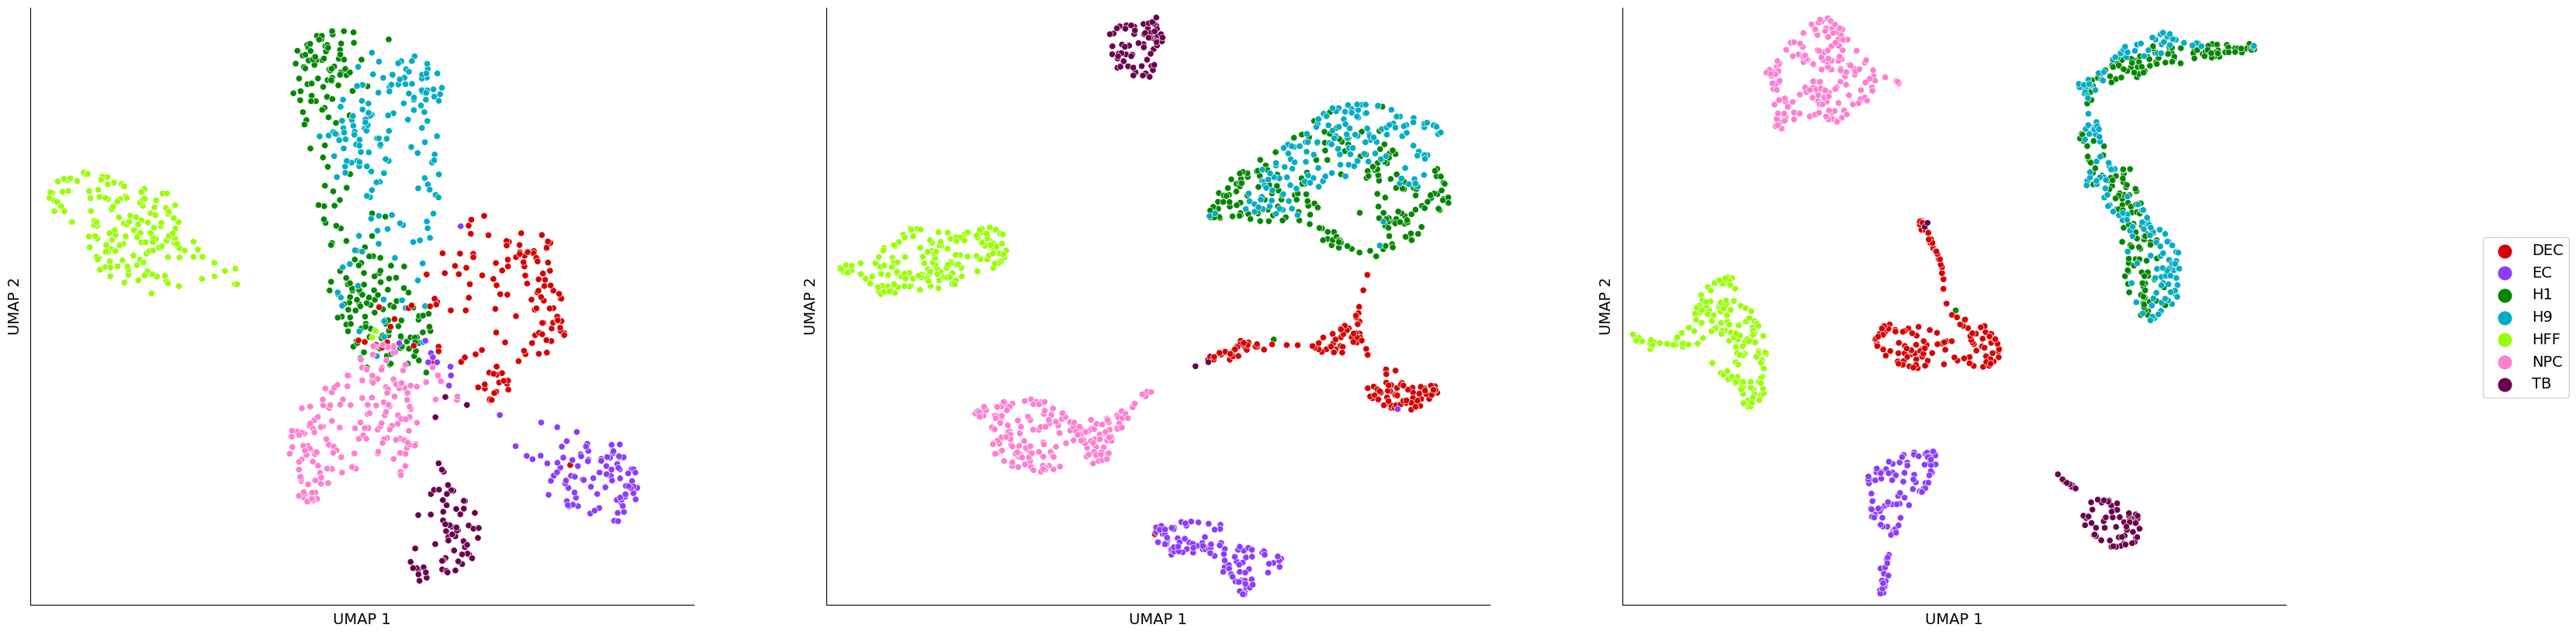

In [64]:
## raw data
end_emb = get_embedding(adata.raw.X)
end_denoise_emb = get_embedding(denoise)
end_latent_emb = get_embedding(latent)

draw_multiple_umap([end_emb,end_denoise_emb,end_latent_emb], end_label)

### Simulated data

In [52]:
# 读取模拟数据
dataname = "group2_dropout1/counts.tsv"
output_dir = 'group2_dropout1'
transpose = True
adata = prepro(dataname, transpose=transpose)
adata = normalize(adata)

X = adata.X.astype(np.float32)
count_X = np.ceil(X).astype(np.int)

input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

# print原始模拟数据 （非真实值）
raw = pd.DataFrame(adata.raw.X, columns=adata.raw.var_names)[adata.var_names]
raw

Successfully preprocessed 200 genes and 2000 cells


,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
0,38.0,89.0,25.0,398.0,31.0,318.0,352.0,60.0,168.0,21.0,...,25.0,424.0,1072.0,6.0,6.0,233.0,619.0,1571.0,0.0,169.0
1,33.0,36.0,8.0,406.0,27.0,270.0,216.0,0.0,126.0,15.0,...,23.0,224.0,666.0,7.0,0.0,165.0,390.0,0.0,5.0,104.0
2,26.0,96.0,7.0,367.0,21.0,365.0,304.0,10.0,305.0,8.0,...,12.0,263.0,740.0,1.0,5.0,0.0,510.0,1471.0,7.0,100.0
3,0.0,43.0,2.0,321.0,12.0,198.0,258.0,20.0,147.0,10.0,...,21.0,178.0,426.0,3.0,4.0,127.0,261.0,1609.0,3.0,104.0
4,13.0,42.0,13.0,232.0,20.0,166.0,223.0,0.0,139.0,4.0,...,9.0,171.0,379.0,3.0,11.0,60.0,271.0,883.0,0.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20.0,37.0,10.0,235.0,9.0,142.0,174.0,0.0,121.0,3.0,...,0.0,136.0,345.0,0.0,0.0,69.0,321.0,811.0,3.0,52.0
1996,17.0,47.0,0.0,357.0,17.0,289.0,194.0,0.0,176.0,17.0,...,23.0,183.0,383.0,0.0,18.0,102.0,377.0,826.0,6.0,133.0
1997,20.0,45.0,10.0,216.0,21.0,257.0,193.0,12.0,138.0,6.0,...,29.0,289.0,548.0,3.0,6.0,117.0,298.0,1060.0,5.0,65.0
1998,34.0,79.0,3.0,302.0,15.0,206.0,176.0,27.0,242.0,6.0,...,46.0,196.0,360.0,3.0,5.0,143.0,303.0,1244.0,0.0,106.0


scDMFK Denoising...

In [57]:
model = scDMFK(output_dir, input_size, dims=[64, 32],learning_rate=0.001)
denoise, latent = model.pretrain(X, count_X, size_factor, batch_size=64, pretrain_epoch=300, gpu_option='0')
pd.DataFrame(denoise, index=adata.obs_names, columns=adata.var_names)

Begin the pretraining...


100%|██████████| 100/100 [00:06<00:00, 14.98it/s]

Training done!


,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
Cell1,1.281115,1.790273,1.419018,1.485998,1.894904,1.642538,1.593598,2.183819,1.131626,3.595827,...,1.392200,1.499731,1.636496,1.762949,2.427022,1.681158,1.341263,1.342799,1.884031,2.029279
Cell2,4.131631,2.926945,1.829771,2.140902,2.786024,2.745254,2.625400,2.178306,2.094770,7.098394,...,2.106498,2.797089,2.341128,6.386581,2.459806,2.464672,3.303752,1.672996,5.390748,3.201601
Cell3,1.005782,2.076889,0.752553,1.446898,2.056682,1.596439,1.324945,1.187021,1.789901,2.264960,...,1.718700,1.354790,1.304479,3.315933,1.685837,1.149911,1.027006,1.316835,2.150634,1.167312
Cell4,0.709844,1.031507,0.814471,0.846834,1.022170,1.055995,0.883406,1.568059,0.732048,1.087702,...,1.143587,0.965770,0.894854,1.002490,1.611295,0.966984,0.759037,0.954231,1.269672,1.155478
Cell5,2.047275,1.047357,1.960526,0.700913,1.135469,0.989014,1.077191,1.094477,0.677794,0.217922,...,2.001549,0.980902,1.150133,0.646896,1.926018,1.196639,0.841391,0.886895,0.948625,1.490387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell1996,0.401836,0.787601,0.219247,0.488367,0.506761,0.538915,0.586206,0.380265,0.600681,0.406547,...,0.308929,0.638303,0.418056,0.468161,0.385443,0.539879,0.471753,0.513194,1.081318,0.411234
Cell1997,1.730780,1.134330,1.054186,1.002211,1.255293,1.131742,1.191737,0.733575,1.320792,0.710629,...,1.131932,1.104552,0.838496,2.029885,1.339050,1.182215,1.048618,0.953144,2.267867,1.519667
Cell1998,0.641174,0.836859,1.079856,0.708800,1.051905,0.866450,0.873138,0.750660,0.830072,0.778264,...,0.852482,0.870618,0.668749,1.070801,0.814912,1.040338,0.847513,0.768089,2.205317,0.993664
Cell1999,1.707959,1.839393,1.897363,1.480110,1.946106,1.699695,1.835514,1.690723,1.257505,6.504203,...,1.774538,1.354752,1.349497,1.189758,2.089497,1.467822,1.391108,1.144819,2.111809,1.765520


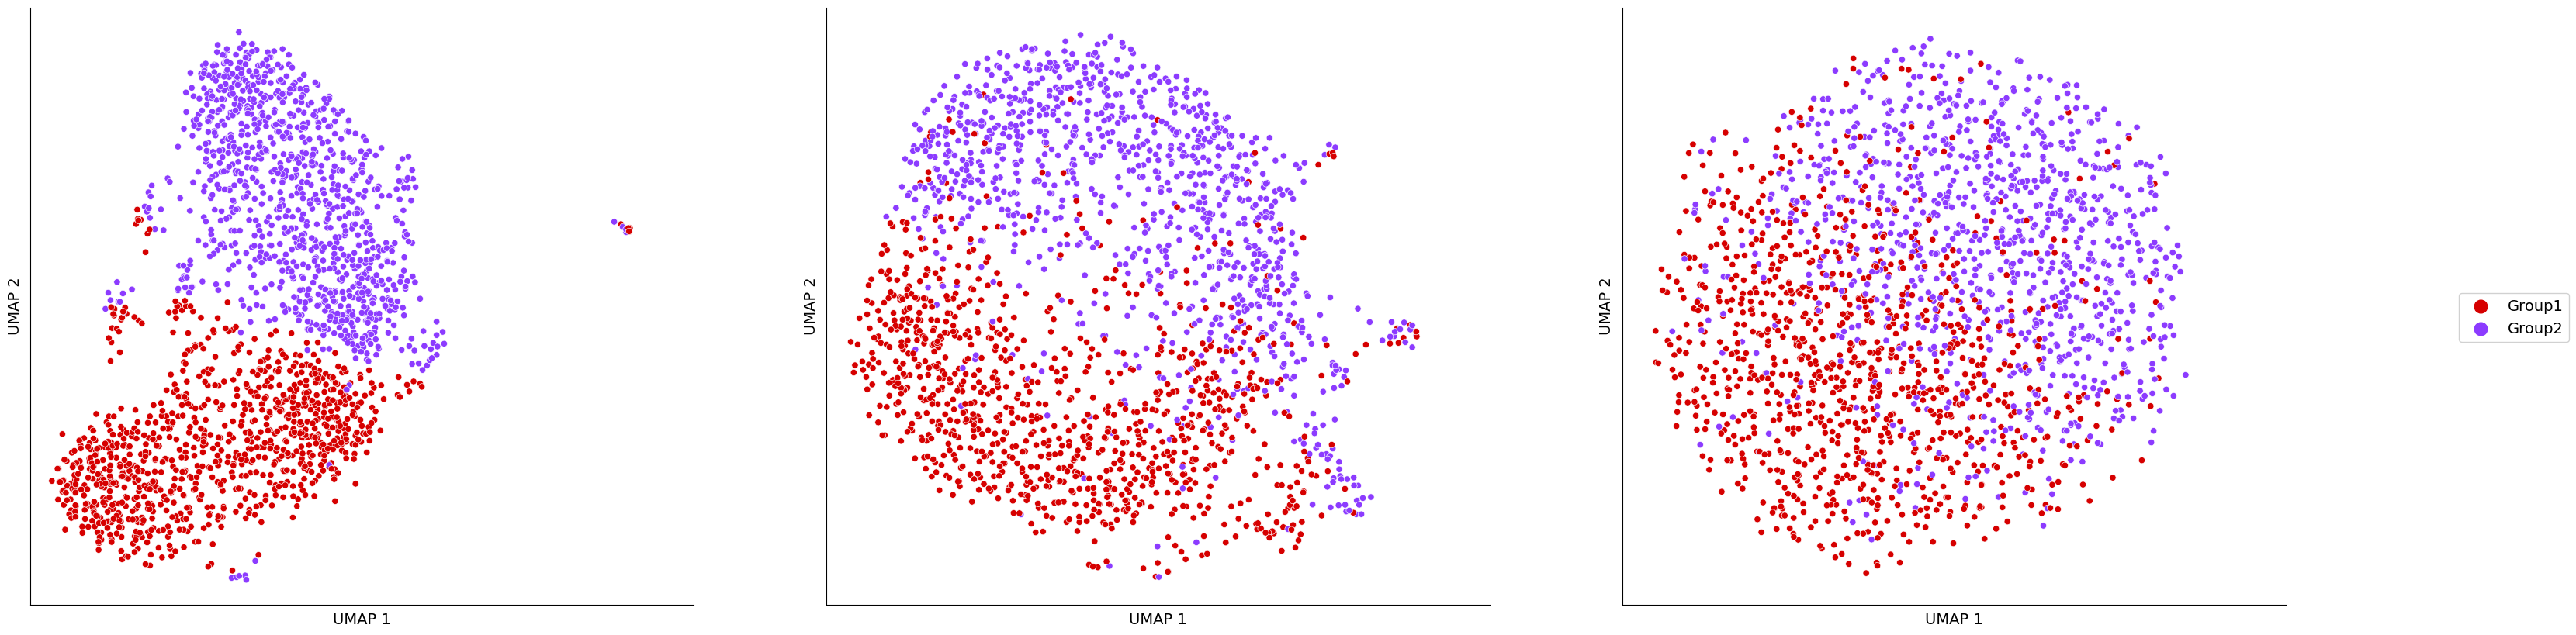

In [60]:
sim_label= pd.read_csv('data/group2_dropout1/info_cellinfo.tsv', sep='\t')['Group']
## raw data
sim_emb = get_embedding(adata.raw.X)
# sim_denoise_emb = get_embedding(denoise)
# sim_latent_emb = get_embedding(latent)

draw_multiple_umap([sim_emb, sim_denoise_emb, sim_latent_emb], sim_label)

## Analysis: Clustering

Clustering with scDMFK denoised (?) data

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


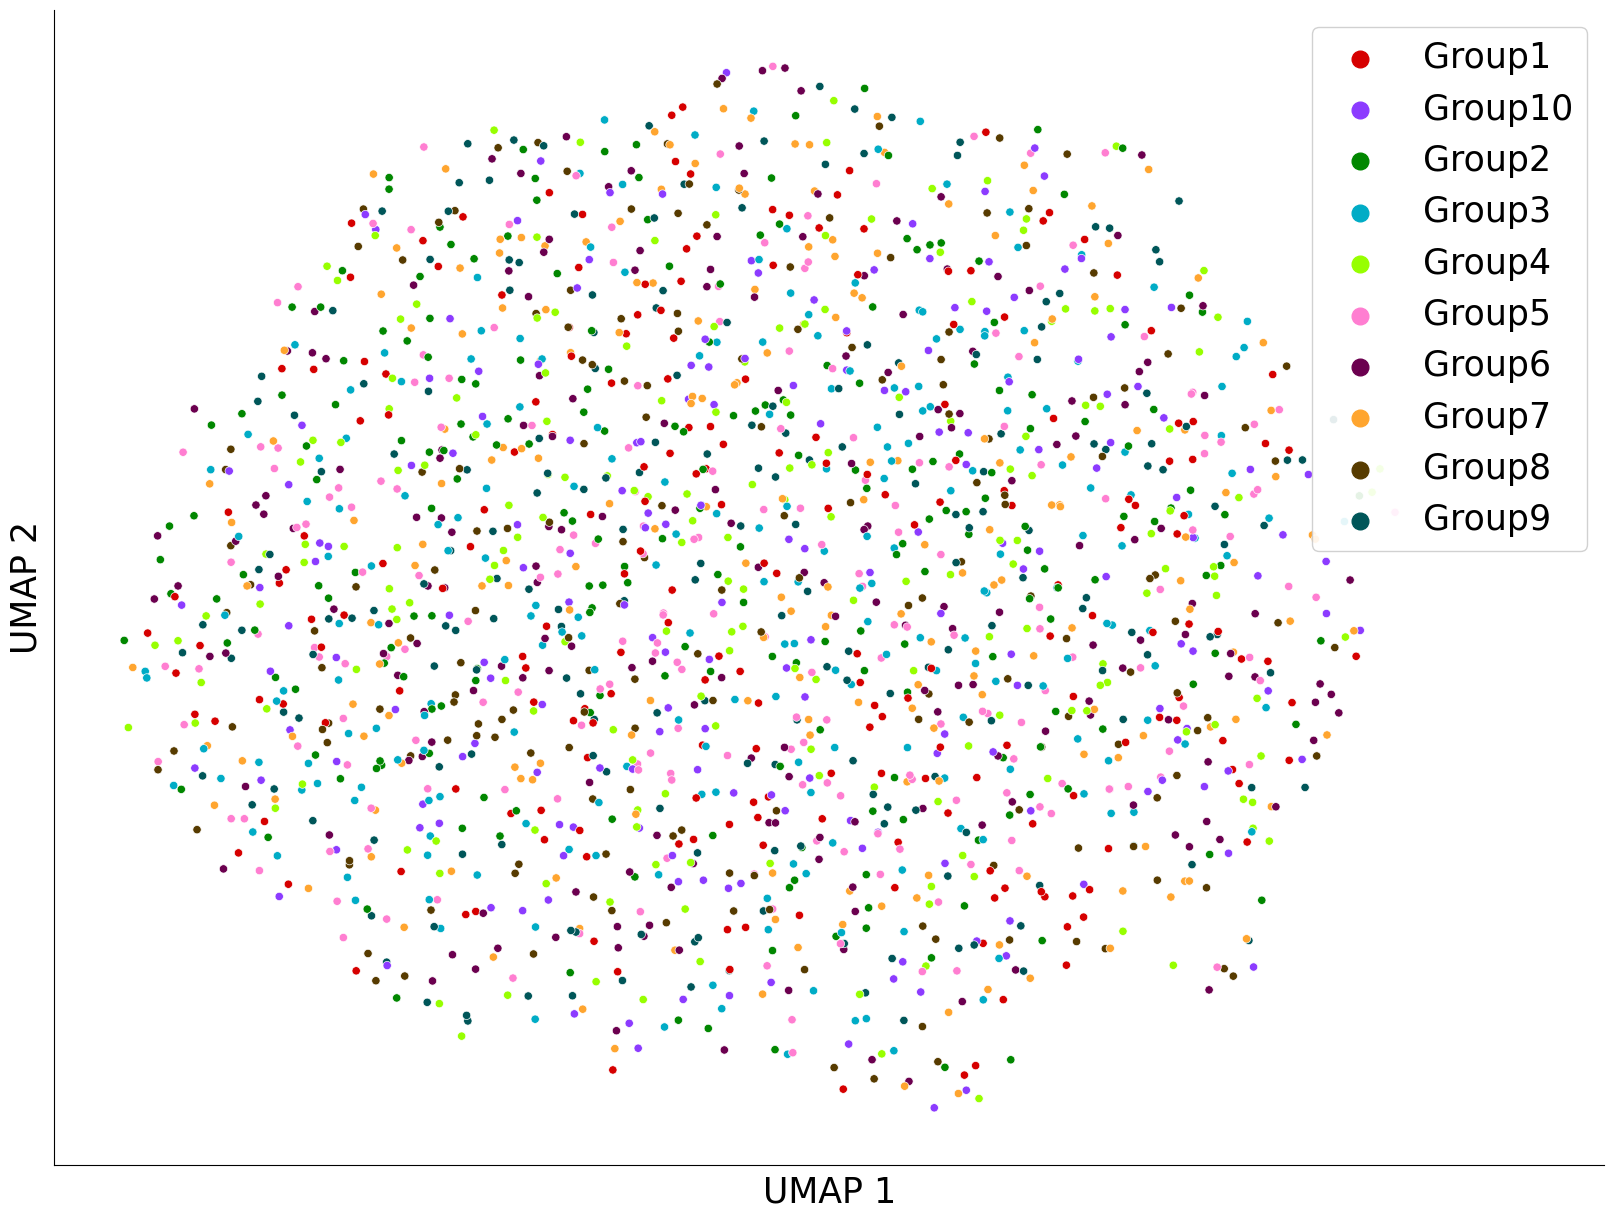

In [47]:
sim_scdm_emb = get_embedding(denoise)
draw_umap(sim_scdm_emb, sim_label)

#### DCA results

In [63]:
!python -m dca.__main__ data/group10_dropout5/counts.tsv results/group10_dropout5/ 

Using TensorFlow backend.

2024-04-20 13:06:10,035 [WARNING] From /Users/yufeideng/Documents/GitHub/bis687-project/dca/train.py:105: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

2024-04-20 13:06:10.036574: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
dca: Successfully preprocessed 200 genes and 2000 cells.
2024-04-20 13:06:10.649467: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
coun

Clustering with DCA denoised data

In [64]:
sim_dca = pd.read_csv('results/group10_dropout5/mean.tsv', sep='\t', index_col=0)
sim_dca

,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,Cell10,...,Cell1991,Cell1992,Cell1993,Cell1994,Cell1995,Cell1996,Cell1997,Cell1998,Cell1999,Cell2000
Gene1,3.661232,2.715294,5.549321,4.026049,2.636076,3.718536,4.106007,2.118743,1.957288,5.457618,...,2.231921,1.711946,4.109773,10.146824,4.031391,3.676610,5.741601,5.230560,6.034132,1.421102
Gene2,30.949125,21.206753,20.455433,20.034708,9.409648,23.742647,16.501753,4.645788,7.091904,32.737095,...,10.043410,8.384529,14.873137,34.222015,13.874279,6.782467,16.912752,14.450267,14.102468,15.069413
Gene3,0.437875,1.178412,0.805057,1.809369,1.567174,1.165566,2.497094,0.197564,0.538678,0.428294,...,0.514327,1.548302,0.917513,0.319445,0.153601,0.200575,0.406133,1.336224,0.657988,0.446966
Gene4,464.260468,337.373260,325.962006,309.561584,248.114105,269.349579,319.835327,178.518448,209.789276,388.342224,...,292.574982,276.616791,259.178131,425.900391,303.454742,217.640930,275.600647,251.232254,273.215424,285.271271
Gene5,3.742484,2.626760,1.281094,3.811470,1.846036,1.981426,2.391545,1.571505,0.784448,2.345070,...,1.533118,1.442765,3.294640,4.986814,6.537007,1.626631,1.955098,2.027989,2.810319,0.657777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gene196,163.160248,70.465630,59.494709,38.758587,25.780212,45.900585,48.108856,18.511572,17.184090,57.714706,...,50.215256,41.878304,38.299213,86.582306,24.328943,23.449327,63.270737,38.602715,36.473396,72.462433
Gene197,538.556458,430.869568,445.577209,357.279083,294.746338,368.379883,317.146973,177.206421,291.058929,476.567719,...,254.077438,326.780182,268.176971,503.224091,335.209137,305.955261,336.167969,282.807648,320.469269,315.118988
Gene198,1809.347412,1276.316528,1311.912964,1219.574829,924.695740,972.218262,1210.039185,628.356445,873.790283,1261.099365,...,1070.015625,1037.201782,944.297241,1504.338867,988.153320,922.685425,1058.494141,977.130615,996.788147,1089.239136
Gene199,0.166265,0.360609,0.498598,1.098108,0.055692,0.410468,0.069059,0.013065,1.208467,0.044944,...,0.102723,0.797288,0.393971,0.826277,0.254574,0.313170,0.715771,0.076423,0.059349,0.038643


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


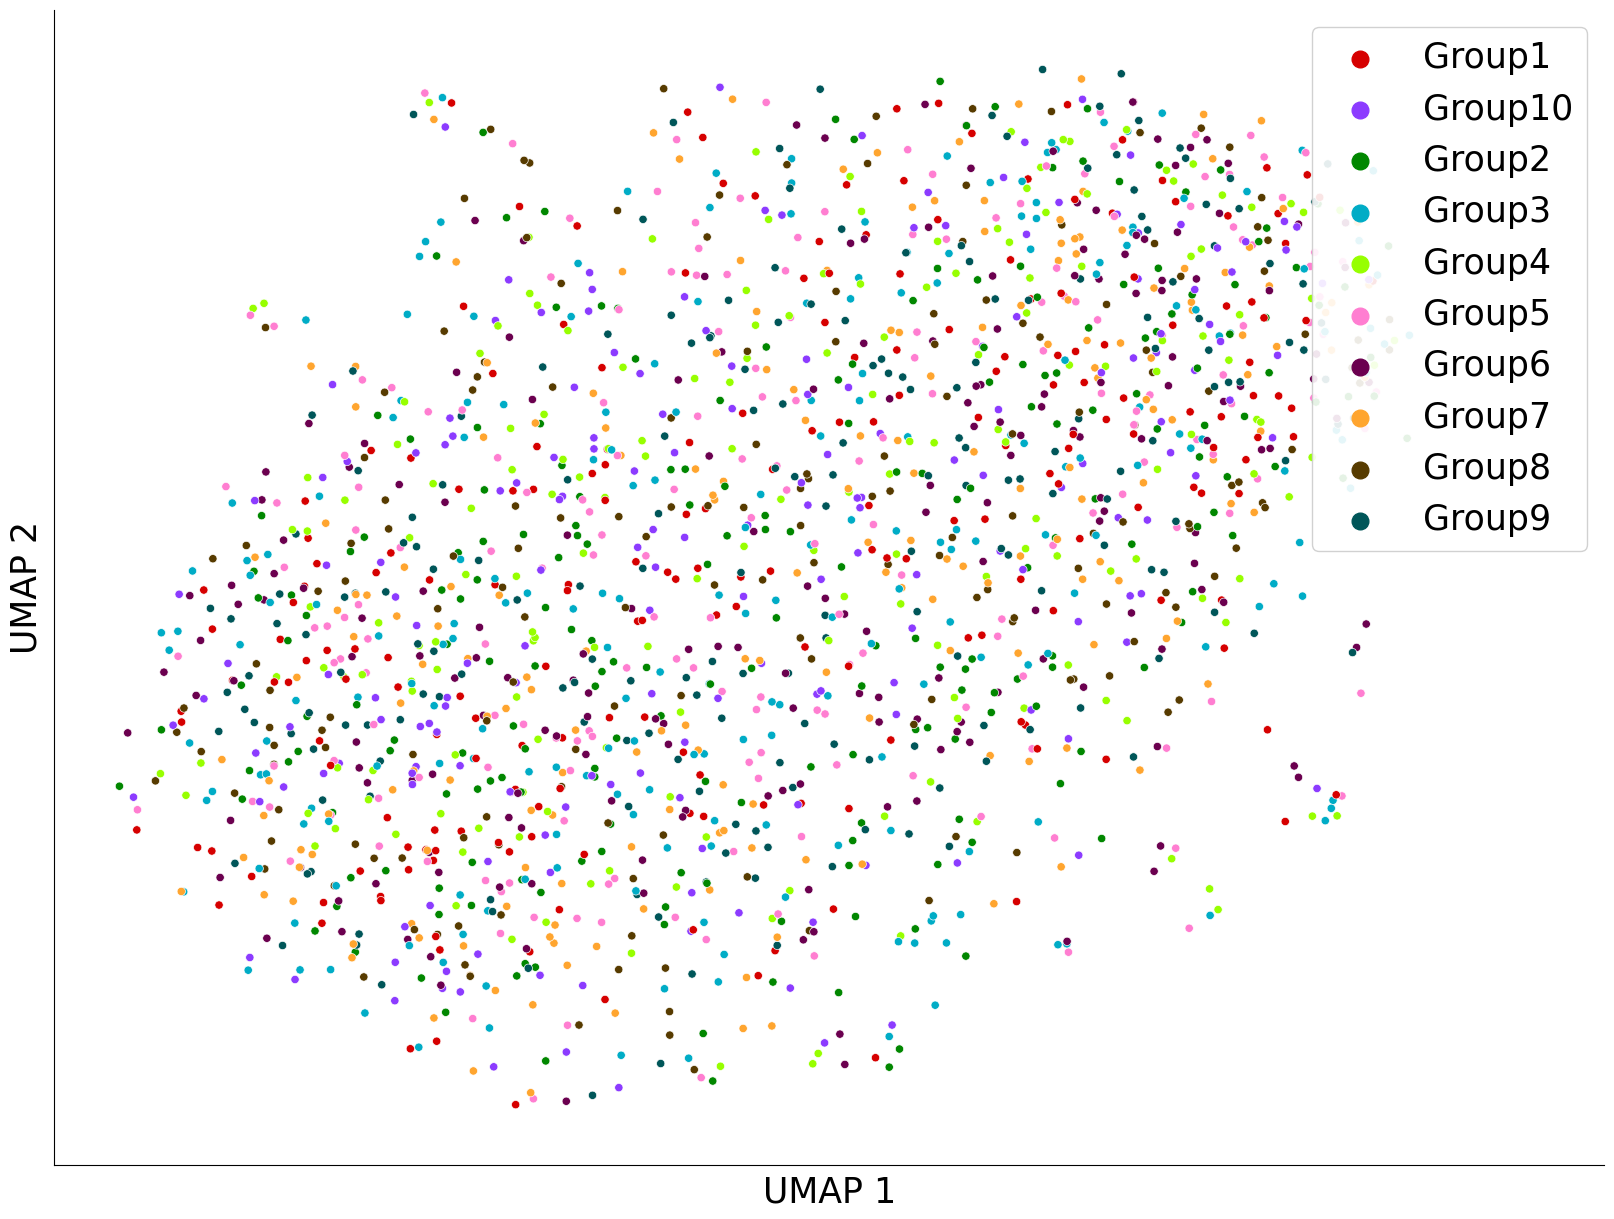

In [65]:
sim_dca_emb = get_embedding(sim_dca.T.values)
draw_umap(sim_dca_emb, sim_label)